In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#1 Initialisation

In [2]:
# parametres de references
K_x, K_y, sigma_x, sigma_y, pho = 0.07173132, 0.08930784, 0.09465584, 0.094675523, -0.999318


def X_ZC(T, para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  return sigma_x * (1 - np.exp(-K_x*T)) / (K_x * T)

def X_FWD(T,para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  return sigma_x * np.exp(-K_x*T)

def Y_ZC(T,para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  return sigma_y * (1 - np.exp(-K_y*T)) / (K_y * T)

def Y_FWD(T,para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  return sigma_y * np.exp(-K_y*T)

def cov(X,Y,T_i, T_j,para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  a = X(T_i,para)*X(T_j,para) + Y(T_i,para)*Y(T_j,para)
  b = X(T_i,para)*Y(T_j,para) + X(T_j,para)*Y(T_i,para)
  return a + pho * b

def corr(X,Y,T_i, T_j,para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  a = X(T_i,para)**2 + Y(T_i,para)**2 + 2*pho*X(T_i,para)*Y(T_i,para)
  b = X(T_j,para)**2 + Y(T_j,para)**2 + 2*pho*X(T_j,para)*Y(T_j,para)
  return cov(X,Y,T_i, T_j,para) / np.sqrt(a*b)

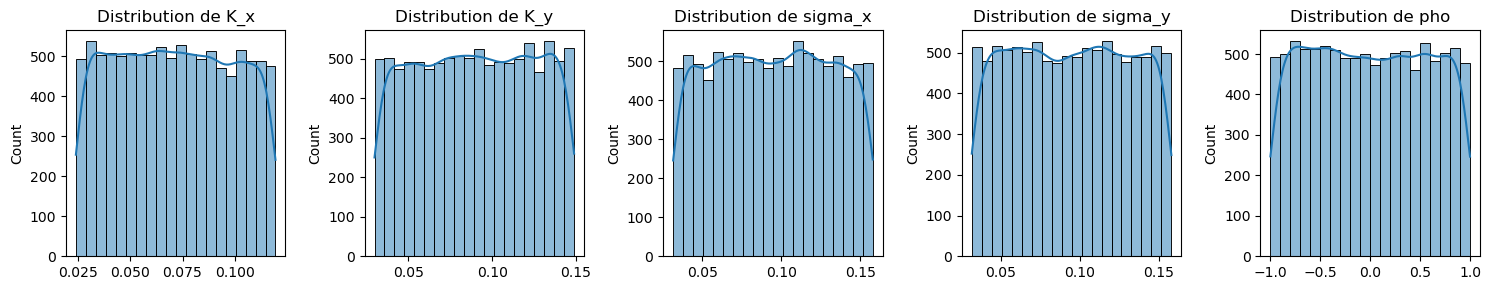

In [4]:
np.random.seed(42)

def para(N):
  min = [0.02391044, 0.02976928, 0.03155195, 0.03155851, -0.999318]
  max = [0.1195522, 0.1488464, 0.15775973, 0.15779254, 0.999318]

  result = np.zeros((N,5))
  for i in range(5):
    result[:,i] = np.random.uniform(min[i], max[i], N)

  return result

name = ['K_x', 'K_y', 'sigma_x', 'sigma_y', 'pho']
N = 10000
result = para(N)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    sns.histplot(result[:,i], kde=True, bins=20, ax=axes[i])
    axes[i].set_title("Distribution de {}".format(name[i]))
    
plt.tight_layout()
plt.show()

#2 Methode Indirect

***2.1: Cov ZC***

In [5]:
maturity_cov = []
for i in range(1,13):
  for j in range(i,13):
    maturity_cov.append([i,j])
print('nf cov:',len(maturity_cov))

maturity_corr = []
for i in range(1,12):
  for j in range(i,12):
    maturity_corr.append([i,j])
print('nf corr:',len(maturity_corr))

nf cov: 78
nf corr: 66


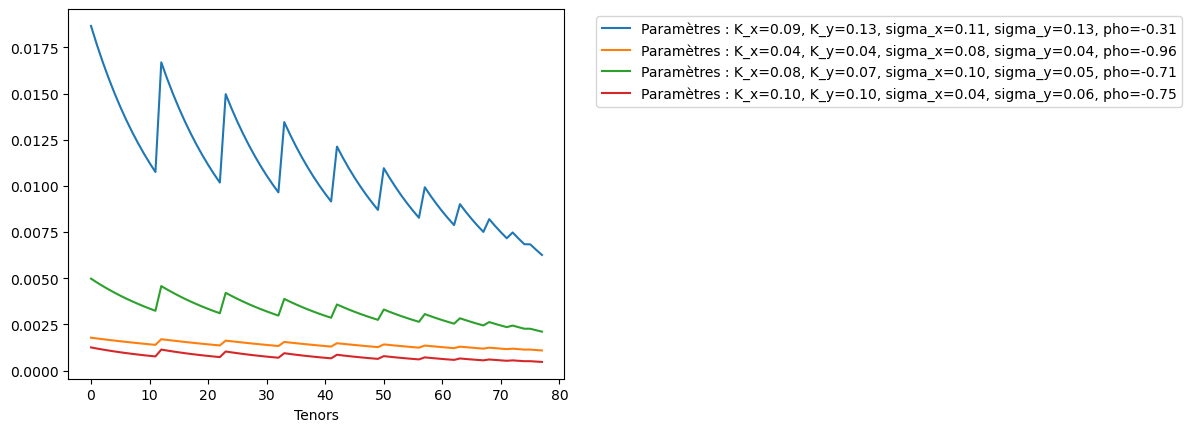

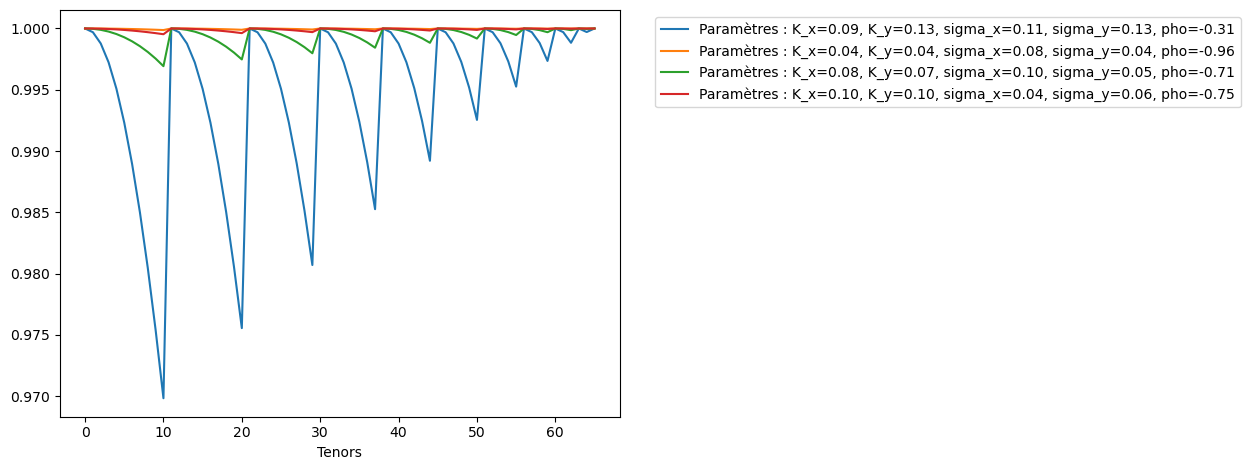

In [6]:
cov_test = []
corr_test = []
Para = []

for k in range(4):
    ind = np.random.randint(0, 10000)
    para = result[ind]
    Para.append(para)
    l_cov, l_corr = [], []

    for i in range(66):
      T_i, T_j = maturity_cov[i]
      T_i2, T_j2 = maturity_corr[i]
      l_cov.append(cov(X_ZC, Y_ZC, T_i, T_j, para))
      l_corr.append(corr(X_FWD, Y_FWD, T_i2, T_j2, para))

    for i in range(66,78):
      T_i, T_j = maturity_cov[i]
      l_cov.append(cov(X_ZC, Y_ZC, T_i, T_j, para))

    cov_test.append(l_cov)
    corr_test.append(l_corr)

for i, sublist in enumerate(cov_test):
    plt.plot(sublist, label='Paramètres : K_x={:.2f}, K_y={:.2f}, sigma_x={:.2f}, sigma_y={:.2f}, pho={:.2f}'.format(*Para[i]))
    plt.xlabel('Tenors')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

for i, sublist in enumerate(corr_test):
    plt.plot(sublist, label='Paramètres : K_x={:.2f}, K_y={:.2f}, sigma_x={:.2f}, sigma_y={:.2f}, pho={:.2f}'.format(*Para[i]))
    plt.xlabel('Tenors')

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [26]:
from tqdm import tqdm

X_cov = np.zeros((len(result), len(maturity_cov)))

for k in tqdm(range(len(result))):
    para = result[k]
    l_cov = []

    for i in range(len(maturity_cov)):
      T_i, T_j = maturity_cov[i]
      l_cov.append(cov(X_ZC, Y_ZC, T_i, T_j, para))
    X_cov[k] = l_cov

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 388.28it/s]


In [ ]:
print(X_cov.shape)

(10000, 78)


In [27]:
y = result

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cov, y, test_size=0.2, random_state=42)

In [29]:
X_train[:,0]

array([0.01838053, 0.00711996, 0.01020344, ..., 0.03082676, 0.00026888,
       0.0064435 ])

In [30]:
y_train[0,:]

array([ 0.0976325 ,  0.04725867,  0.15136091,  0.08981906, -0.39962811])

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test= scaler.transform(y_test)

In [ ]:
X_train[:,0]

array([0.20478382, 0.07915695, 0.11355733, ..., 0.34363844, 0.00272379,
       0.0716101 ])

In [ ]:
y_train[0,:]

array([0.77102954, 0.14675095, 0.94939086, 0.46162236, 0.30004622])

In [ ]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(8000, 78)
(8000, 5)

(2000, 78)
(2000, 5)


In [38]:
# Définir le modèle
model = tf.keras.Sequential([
    layers.Dense(1000, activation='relu', input_shape=(78,)),  # Couche d'entrée
    layers.Dense(1500, activation='relu'),  # Première couche cachée
    layers.Dense(1000, activation='relu'),  # Deuxième couche cachée
    layers.Dropout(0.25),  # Dropout
    layers.Dense(5)  # Couche de sortie
])

# Compiler le modèle
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=1000, validation_data=(X_test, y_test))


Epoch 1/100


C:\Users\Alouadi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.2256 - val_loss: 0.1144
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.1136 - val_loss: 0.0865
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0803 - val_loss: 0.0637
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0661 - val_loss: 0.0604
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0626 - val_loss: 0.0584
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0607 - val_loss: 0.0573
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0604 - val_loss: 0.0571
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0595 - val_loss: 0.0566
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0584 - val_loss: 0.0560
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0582 - val_loss: 0.0560
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0578 - val_loss: 0.0556
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0579 - val_loss: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step



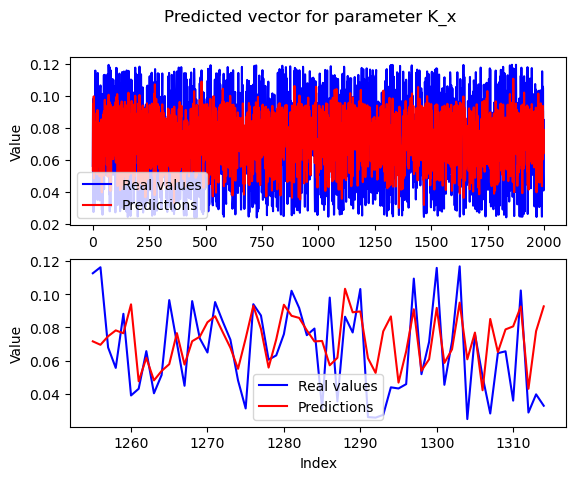

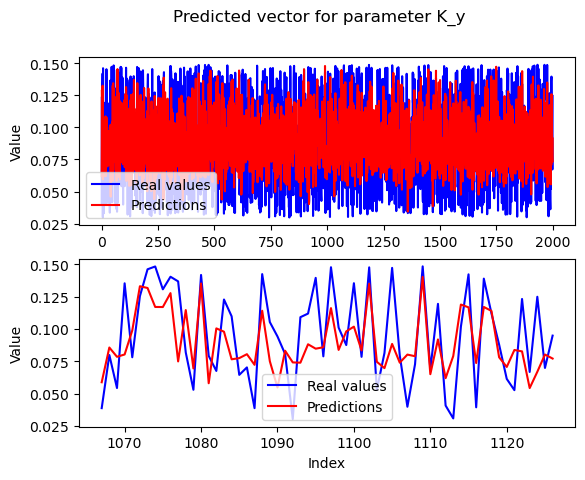

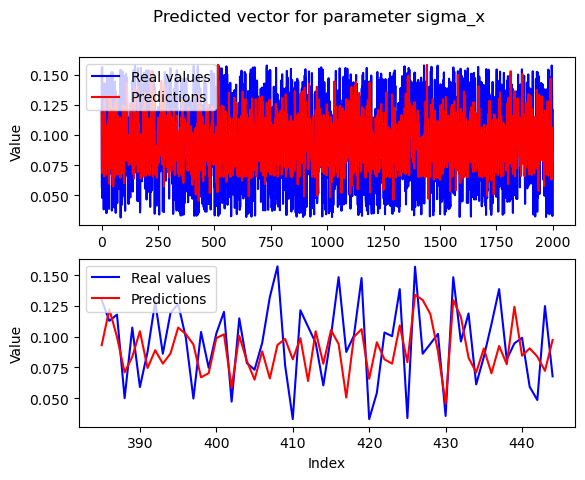

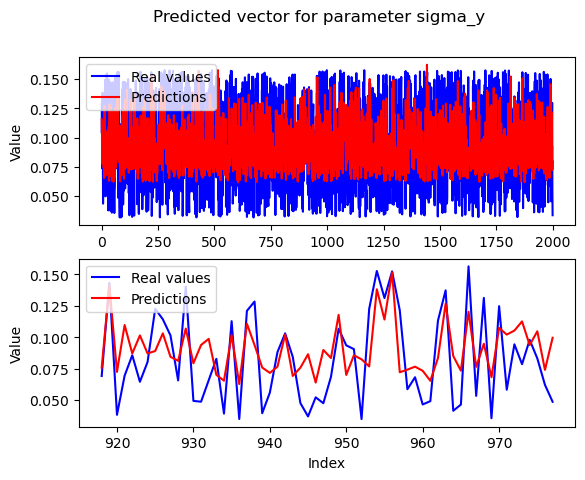

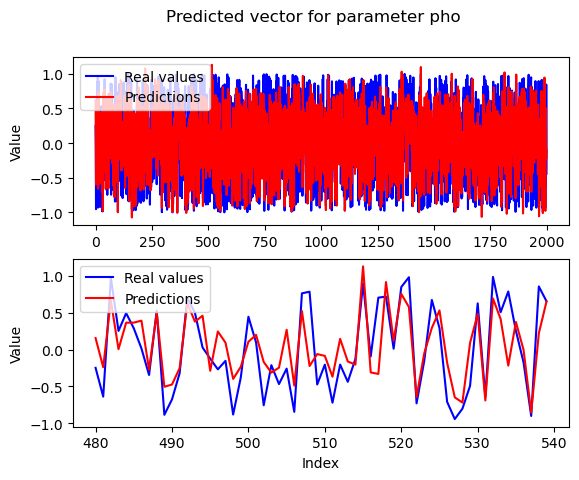

In [42]:
y_pred = model.predict(X_test)

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred)

parameters = ['K_x', 'K_y', 'sigma_x', 'sigma_y', 'pho']

for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2)  # Créer 2 subplots
    fig.suptitle('Predicted vector for parameter {}'.format(parameter))

    # Tracer le vecteur global
    axs[0].plot(y_test_original[:, i], c='b', label='Real values')
    axs[0].plot(y_pred_original[:, i], c='r', label='Predictions')
    axs[0].set_ylabel('Value')
    axs[0].legend()

    
    ind = np.random.randint(0,1938)
    x = np.arange(ind, ind+60) 
    axs[1].plot(x, y_test_original[ind:ind+60, i], c='b', label='Real values')
    axs[1].plot(x, y_pred_original[ind:ind+60, i], c='r', label='Predictions')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    print()

    plt.show()


In [43]:
results = model.evaluate(X_test, y_test, batch_size=1000)
print("test loss", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0523
test loss 0.052889760583639145


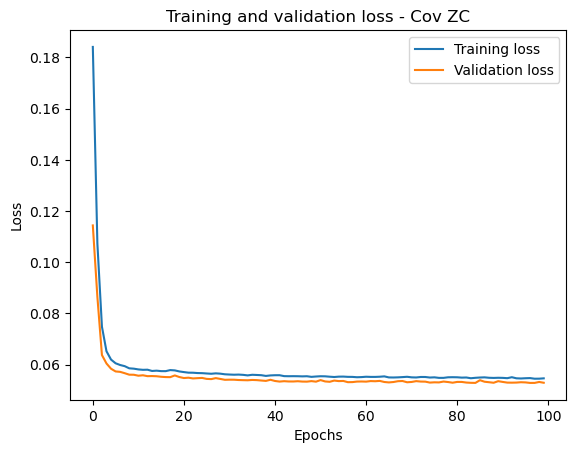

In [44]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss - Cov ZC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [45]:
MSE = np.mean((y_test_original - y_pred_original)**2, axis = 0)
M = ["{:.1e}".format(x) for x in MSE] # format scientifique
Cal = {'Parameters': parameters,
        'MSE': M}


Cal_table = pd.DataFrame(Cal).transpose()

In [46]:
MSE

array([0.0004802 , 0.00072379, 0.00096939, 0.00098346, 0.15270692])

In [47]:
Cal_table

,0,1,2,3,4
Parameters,K_x,K_y,sigma_x,sigma_y,pho
MSE,4.8e-04,7.2e-04,9.7e-04,9.8e-04,1.5e-01


***2.2: Corr FWD***

In [48]:
from tqdm import tqdm

X_corr = np.zeros((len(result), len(maturity_corr)))
for k in tqdm(range(len(result))):
    para = result[k]
    l_corr = []

    for i in range(len(maturity_corr)):
      T_i, T_j = maturity_corr[i]
      l_corr.append(corr(X_FWD, Y_FWD, T_i, T_j, para))
    X_corr[k] = l_corr

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 242.56it/s]


In [ ]:
print(X_corr.shape)

(10000, 66)


In [ ]:
X_corr[:1,:]

array([[1.        , 0.99993962, 0.99975921, 0.99946003, 0.99904347,
        0.99851111, 0.99786466, 0.99710599, 0.9962371 , 0.99526011,
        0.9941773 , 1.        , 0.99993998, 0.99976076, 0.99946368,
        0.99905026, 0.99852217, 0.99788122, 0.99712937, 0.9962687 ,
        0.99530143, 1.        , 0.99994039, 0.99976246, 0.99946767,
        0.99905764, 0.99853413, 0.99789906, 0.99715445, 0.99630248,
        1.        , 0.99994084, 0.99976431, 0.99947199, 0.99906558,
        0.99854696, 0.99791811, 0.99718115, 1.        , 0.99994131,
        0.9997663 , 0.99947661, 0.99907407, 0.99856062, 0.99793833,
        1.        , 0.99994183, 0.99976842, 0.99948154, 0.99908308,
        0.99857507, 1.        , 0.99994238, 0.99977067, 0.99948675,
        0.99909258, 1.        , 0.99994296, 0.99977305, 0.99949223,
        1.        , 0.99994357, 0.99977555, 1.        , 0.9999442 ,
        1.        ]])

In [49]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_corr, y, test_size=0.2, random_state=42)

scaler2 = MinMaxScaler()
X_train2 = scaler2.fit_transform(X_train2)
X_test2 = scaler2.transform(X_test2)
y_train2 = scaler2.fit_transform(y_train2)
y_test2= scaler2.transform(y_test2)

In [ ]:
print(X_train2[:,0])
y_train2[0,:]

[0.328125   0.33203125 0.328125   ... 0.328125   0.328125   0.33203125]


array([0.77102954, 0.14675095, 0.94939086, 0.46162236, 0.30004622])

In [ ]:
print(X_train2.shape)
print(y_train2.shape)

print(X_test2.shape)
print(y_test2.shape)

(8000, 66)
(8000, 5)
(2000, 66)
(2000, 5)


In [50]:
# Définir le modèle
model2 = tf.keras.Sequential([
    layers.Dense(1000, activation='relu', input_shape=(66,)),  # Couche d'entrée
    layers.Dense(1500, activation='relu'),  # Première couche cachée
    layers.Dense(1000, activation='relu'),  # Deuxième couche cachée
    layers.Dropout(0.25),  # Dropout
    layers.Dense(5)  # Couche de sortie
])

# Compiler le modèle
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse')

# Entraîner le modèle
history2 = model2.fit(X_train2, y_train2, epochs=100, batch_size=1000, validation_data=(X_test2, y_test2))

C:\Users\Alouadi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.8729 - val_loss: 0.0840
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.1025 - val_loss: 0.0918
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0927 - val_loss: 0.0829
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0883 - val_loss: 0.0823
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0870 - val_loss: 0.0822
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0855 - val_loss: 0.0821
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0853 - val_loss: 0.0817
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0850 - val_loss: 0.0814
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0848 - val_loss: 0.0813
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0843 - val_loss: 0.0825
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0848 - val_loss: 0.0812
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0842 - 

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step



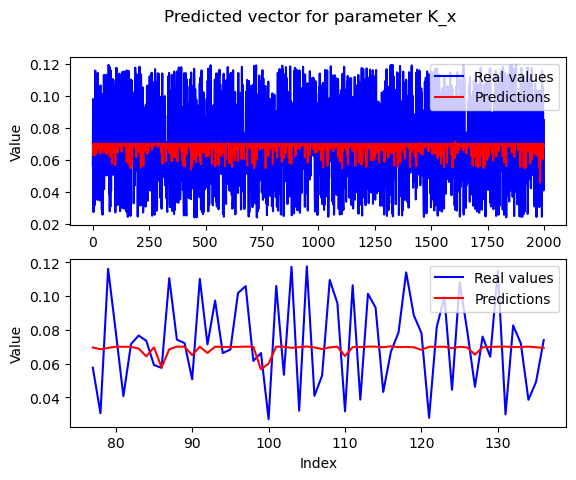

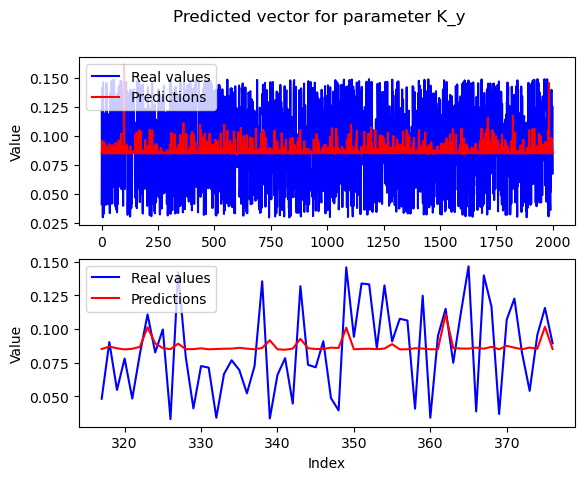

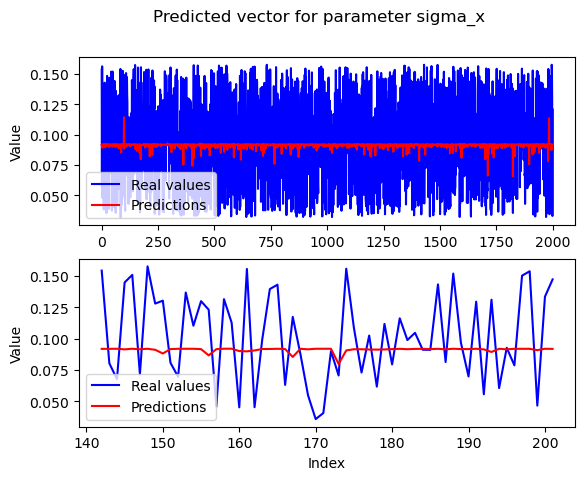

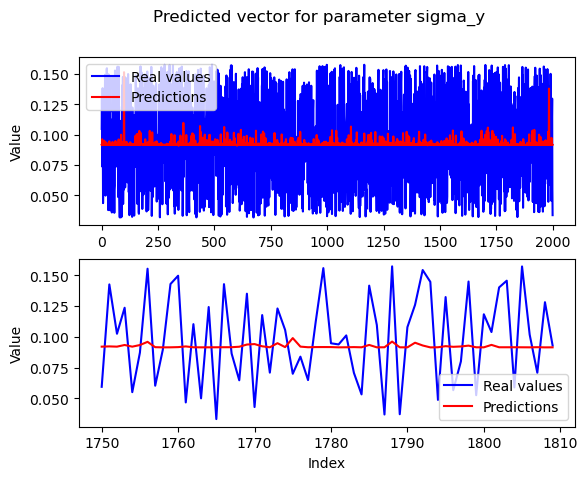

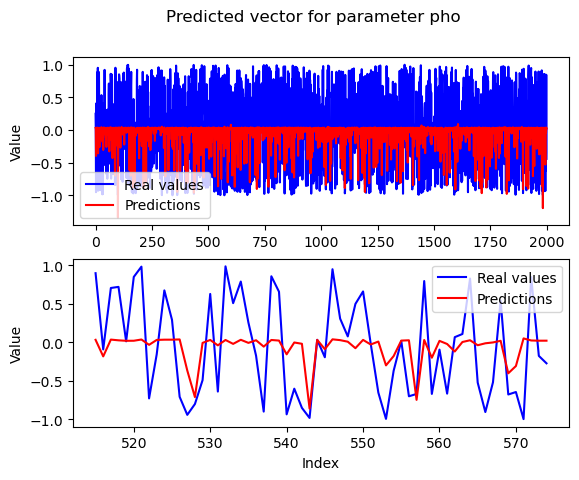

In [51]:
y_pred2 = model2.predict(X_test2)

y_test_original2 = scaler2.inverse_transform(y_test2)
y_pred_original2 = scaler2.inverse_transform(y_pred2)



for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2)  
    fig.suptitle('Predicted vector for parameter {}'.format(parameter))

    # Tracer le vecteur global
    axs[0].plot(y_test_original2[:, i], c='b', label='Real values')
    axs[0].plot(y_pred_original2[:, i], c='r', label='Predictions')
    axs[0].set_ylabel('Value')
    axs[0].legend()

    # Tracer le vecteur zoomé
    ind = np.random.randint(0,1938)
    x = np.arange(ind, ind+60)  
    axs[1].plot(x, y_test_original2[ind:ind+60, i], c='b', label='Real values')
    axs[1].plot(x, y_pred_original2[ind:ind+60, i], c='r', label='Predictions')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    print()

    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0787
test loss 0.07886506617069244


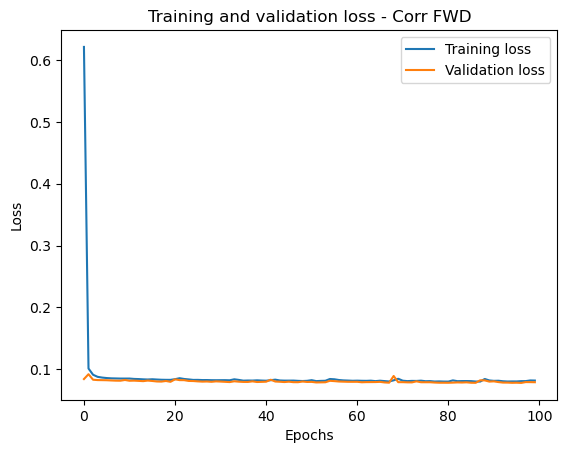

In [52]:
results2 = model2.evaluate(X_test2, y_test2, batch_size=1000)
print("test loss", results2)

plt.figure()
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss - Corr FWD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [53]:
MSE2 = np.mean((y_test_original2 - y_pred_original2)**2, axis = 0)
M2 = ["{:.1e}".format(x) for x in MSE2] # format scientifique
Cal2 = {'Parameters': parameters,
        'MSE': M2}


Cal_table2 = pd.DataFrame(Cal2).transpose()

Cal_table2

,0,1,2,3,4
Parameters,K_x,K_y,sigma_x,sigma_y,pho
MSE,7.4e-04,1.1e-03,1.3e-03,1.3e-03,2.7e-01


In [ ]:
Cal_table

,0,1,2,3,4
Parameters,K_x,K_y,sigma_x,sigma_y,pho
MSE,4.8e-04,7.2e-04,9.6e-04,9.7e-04,1.5e-01


#3 Methode Direct

In [54]:
# Initialisation

def V(t,T, para):
  K_x, K_y, sigma_x, sigma_y, pho = para
  T_ = T - t
  a = T_ + (2/K_x)*np.exp(-K_x*T_) - (0.5/K_x)*np.exp(-2*K_x*T_) - 1.5/K_x
  b = T_ + (2/K_y)*np.exp(-K_y*T_) - (0.5/K_y)*np.exp(-2*K_y*T_) - 1.5/K_y
  K_ = K_x + K_y
  coeff = 2*pho*(sigma_x*sigma_y)/(K_x * K_y)
  c = T_ + (np.exp(-K_x*T_) - 1)/K_x + (np.exp(-K_y*T_) - 1)/K_y - (np.exp(-K_*T_) - 1)/K_
  return (sigma_x/K_x)**2 * a + (sigma_y/K_y)**2 * b + coeff * c

def V2(t,T,para):
  return 0.5/T * (V(t,T,para) - V(0,T,para) + V(0,t,para) )

def E_ZC(para, PM):
  mat = np.zeros((len(nb_step), len(nb_tenors)))
  for i in range(len(nb_step)):
    t_i = nb_step[i]
    for j in range(len(nb_tenors)):
      T_j = nb_tenors[j]
      mat[i,j] = 1/T_j * np.log(PM[j]/PM_interpolated[i]) - V2(t_i,T_j, para)
  return mat

In [75]:
nb_step = np.array([i for i in range(106)])*7/365
nb_tenors = np.array([3/12, 6/12, 9/12]+[i for i in range(1,21)]+[25,30])

# Données fournies
data = {
    '3 months': 3.837466,
    '6 months': 3.652828,
    '9 months': 3.488389,
    '1 year': 3.342178,
    '2 years': 2.906372,
    '3 years': 2.646339,
    '4 years': 2.501166,
    '5 years': 2.430029,
    '6 years': 2.405642,
    '7 years': 2.409838,
    '8 years': 2.430593,
    '9 years': 2.460012,
    '10 years': 2.492977,
    '11 years': 2.526227,
    '12 years': 2.557748,
    '13 years': 2.586349,
    '14 years': 2.611389,
    '15 years': 2.632583,
    '16 years': 2.649877,
    '17 years': 2.663360,
    '18 years': 2.673214,
    '19 years': 2.679666,
    '20 years': 2.682971,
    '25 years': 2.661341,
    '30 years': 2.596751
}



values = list(data.values())
PM = np.array(values)
print(PM)

PM_interpolated = np.interp(nb_step, np.arange(len(PM)), PM) # valeurs de PM les 106 premieres semaines

print()
print(len(nb_tenors))

[3.837466 3.652828 3.488389 3.342178 2.906372 2.646339 2.501166 2.430029
 2.405642 2.409838 2.430593 2.460012 2.492977 2.526227 2.557748 2.586349
 2.611389 2.632583 2.649877 2.66336  2.673214 2.679666 2.682971 2.661341
 2.596751]

25


In [56]:
print(nb_tenors.shape) # T_j, dataset de maturité T, nombre de col de X
print(PM.shape) # PM associé à T_j
print(nb_step.shape) # nombre de step de propagation, 2 ans de maturité t_i, nombre de lignes de X
print(PM_interpolated.shape) # PM associé à chaque t_j

(25,)
(25,)
(106,)
(106,)


Lien des datas suivantes: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


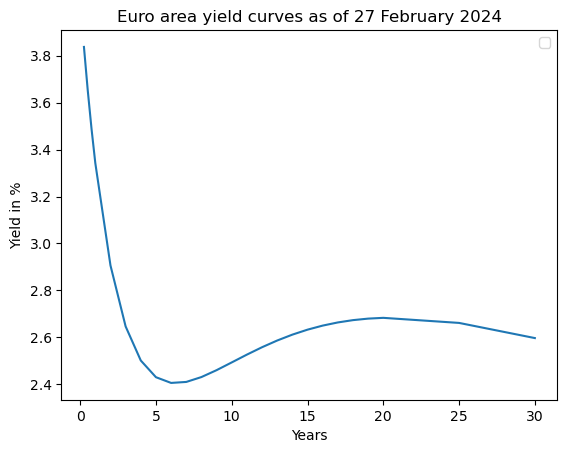

In [58]:
plt.plot(nb_tenors,PM)
plt.xlabel('Years')
plt.ylabel('Yield in %')
plt.title('Euro area yield curves as of 27 February 2024')
plt.legend()
plt.show()

Parameters:  [0.02643222 0.08860835 0.08328804 0.0753606  0.51288721]


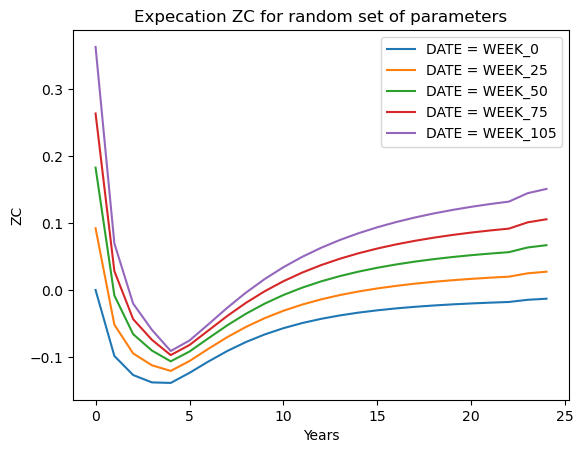

In [60]:
np.random.seed(0)
index = np.random.randint(0,len(result))
para = result[ind]

mat = E_ZC(para, PM)

test_week = [0,25,50,75,105]

print('Parameters: ', para)
for i in test_week:
  plt.plot(mat[i,:], label = 'DATE = WEEK_{}'.format(i))
  plt.xlabel('Years')
  plt.ylabel('ZC')
  plt.title('Expecation ZC for random set of parameters')
  plt.legend()
plt.show()


In [61]:
X_direct = np.zeros((2000,nb_step.shape[0],nb_tenors.shape[0]))

In [62]:
X_direct.shape

(2000, 106, 25)

In [63]:
E_ZC(result[0], PM)

array([[ 3.04647309e-14, -9.86211816e-02, -1.27162971e-01, ...,
        -1.78943745e-02, -1.46392849e-02, -1.30183735e-02],
       [ 3.72911210e-03, -9.67001879e-02, -1.25820446e-01, ...,
        -1.68453157e-02, -1.36220970e-02, -1.20532516e-02],
       [ 7.45561535e-03, -9.47833637e-02, -1.24482518e-01, ...,
        -1.57971661e-02, -1.26054893e-02, -1.10885016e-02],
       ...,
       [ 3.61380184e-01,  7.07254120e-02, -1.87843717e-02, ...,
         8.40458105e-02,  8.60160543e-02,  8.35564812e-02],
       [ 3.64939389e-01,  7.22020905e-02, -1.79663257e-02, ...,
         8.49650068e-02,  8.69445443e-02,  8.44594870e-02],
       [ 3.68226050e-01,  7.35383038e-02, -1.72445912e-02, ...,
         8.58791412e-02,  8.78691316e-02,  8.53593581e-02]])

In [64]:
from tqdm import tqdm

for i in tqdm(range(X_direct.shape[0])):
  X_direct[i] = E_ZC(result[i], PM)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:52<00:00,  6.85it/s]


In [ ]:
print(X_direct.shape)

(2000, 106, 25)


In [65]:
X_direct = X_direct.reshape(-1, X_direct.shape[1],X_direct.shape[2], 1)

print(X_direct.shape)

(2000, 106, 25, 1)


In [66]:
y = result
print(y.shape)
y_ = y[:X_direct.shape[0],]
y_.shape

(10000, 5)


(2000, 5)

In [67]:
from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_direct, y_, test_size = 0.2, random_state = 0)

In [ ]:
print(X_train3.shape)
print(y_train3.shape)

(1600, 106, 25, 1)
(1600, 5)


In [ ]:
y_train3[0]

array([0.0710253 , 0.08600714, 0.07397423, 0.12832928, 0.24059118])

In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train3 = scaler.fit_transform(y_train3)
y_test3= scaler.transform(y_test3)

In [ ]:
y_train3[0]

array([0.49111904, 0.47235209, 0.33595984, 0.76681454, 0.6197442 ])

In [76]:
cnn = tf.keras.Sequential([
    layers.Conv2D(filters=7,kernel_size=7,activation='relu',input_shape=[106, 25, 1], padding='valid'),
    layers.MaxPooling2D(pool_size=2,strides=2),
    layers.Flatten(),


    layers.Dense(100, activation='relu',),  # Couche d'entrée du NN
    layers.Dropout(0.25),  # Dropout
    layers.Dense(5)  # Couche de sortie
])


# Compiler le modèle
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              loss='mse')

# Entraîner le modèle
history = cnn.fit(X_train3, y_train3, epochs=200, batch_size=50, validation_data=(X_test3, y_test3))


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2423 - val_loss: 0.0888
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0923 - val_loss: 0.0764
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0865 - val_loss: 0.0744
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0827 - val_loss: 0.0725
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0807 - val_loss: 0.0728
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0793 - val_loss: 0.0714
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0776 - val_loss: 0.0706
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0759 - val_loss: 0.0696
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0760 - val_loss: 0.0688
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0746 - val_loss: 0.0675
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0728 - val_loss: 0.0668
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

In [81]:
results = cnn.evaluate(X_test3, y_test3, batch_size=100)
print("test loss", results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0587 
test loss 0.05947822704911232


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step



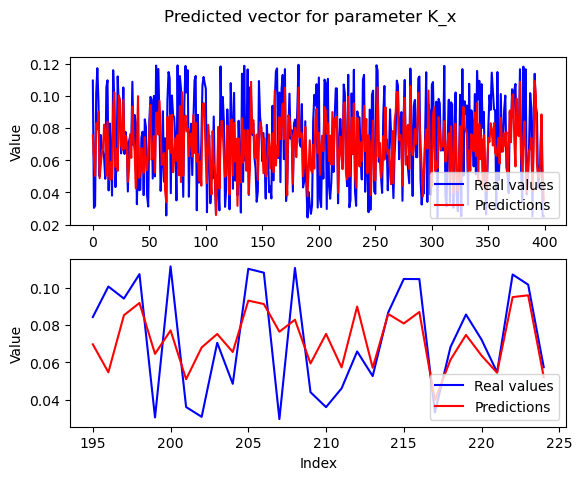

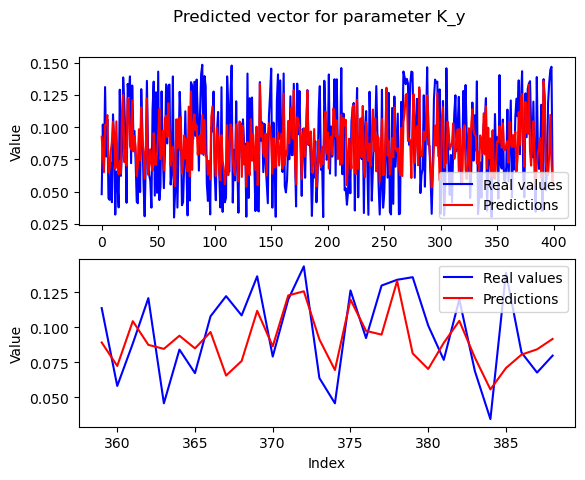

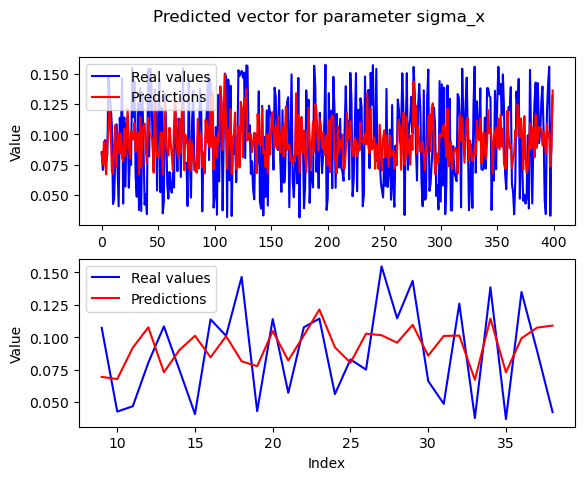

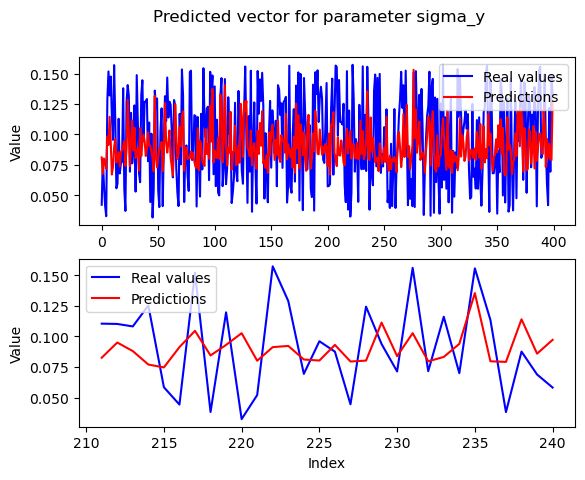

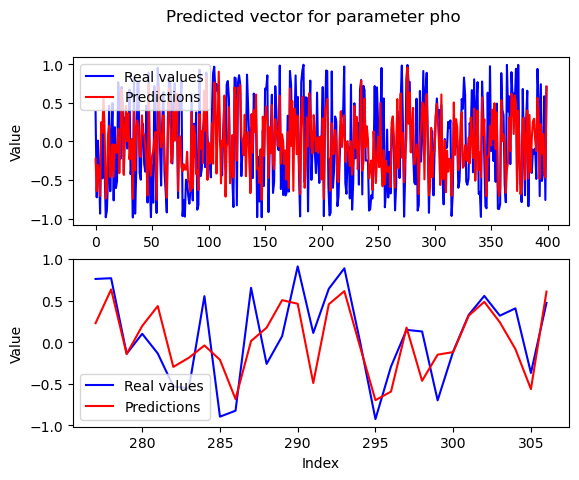

In [82]:
y_pred3 = cnn.predict(X_test3)

y_test_original3 = scaler.inverse_transform(y_test3)
y_pred_original3 = scaler.inverse_transform(y_pred3)

parameters = ['K_x', 'K_y', 'sigma_x', 'sigma_y', 'pho']

for i, parameter in enumerate(parameters):
    fig, axs = plt.subplots(2)  
    fig.suptitle('Predicted vector for parameter {}'.format(parameter))


    axs[0].plot(y_test_original3[:, i], c='b', label='Real values')
    axs[0].plot(y_pred_original3[:, i], c='r', label='Predictions')
    axs[0].set_ylabel('Value')
    axs[0].legend()

    
    ind = np.random.randint(0,y_test3.shape[0]-30)
    x = np.arange(ind, ind+30  
    axs[1].plot(x, y_test_original3[ind:ind+30, i], c='b', label='Real values')
    axs[1].plot(x, y_pred_original3[ind:ind+30, i], c='r', label='Predictions')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Value')
    axs[1].legend()
    print()

    plt.show()

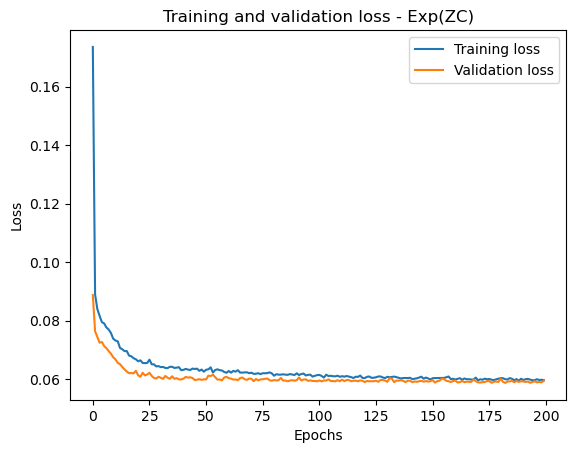

In [80]:
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss - Exp(ZC)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [83]:
MSE3 = np.mean((y_test_original3 - y_pred_original3)**2, axis = 0)
M3 = ["{:.1e}".format(x) for x in MSE2] # format scientifique
Cal3 = {'Parameters': parameters,
        'MSE': M3}


Cal_table3 = pd.DataFrame(Cal3).transpose()


#4 Final Results (MSE)

In [84]:
c1 = Cal_table.transpose()

In [85]:
c2 = Cal_table2.transpose()

In [86]:
c3 = Cal_table3.transpose()

In [87]:
for i in c2['MSE'].values:
  print(i)

7.4e-04
1.1e-03
1.3e-03
1.3e-03
2.7e-01


In [88]:
l1 = [i for i in c1['MSE'].values]
l2 = [i for i in c2['MSE'].values]
l3 = [i for i in c3['MSE'].values]
na = ['COV ZC','CORR FWD','ZC']

l4 = [l1,l2,l3]
print(l4)

final_result = pd.DataFrame(l4, columns=['K_x', 'K_y', 'sigma_x', 'sigma_y', 'pho'])

final_result.insert(0, "MSE",na,True)

[['4.8e-04', '7.2e-04', '9.7e-04', '9.8e-04', '1.5e-01'], ['7.4e-04', '1.1e-03', '1.3e-03', '1.3e-03', '2.7e-01'], ['7.4e-04', '1.1e-03', '1.3e-03', '1.3e-03', '2.7e-01']]


In [89]:
final_result

,MSE,K_x,K_y,sigma_x,sigma_y,pho
0,COV ZC,4.8e-04,7.2e-04,9.7e-04,9.8e-04,1.5e-01
1,CORR FWD,7.4e-04,1.1e-03,1.3e-03,1.3e-03,2.7e-01
2,ZC,7.4e-04,1.1e-03,1.3e-03,1.3e-03,2.7e-01
